In [1]:
import os
import pandas as pd

def load_predictions_data():
    predictions_path=os.path.join("datasets", "predictions_prod_v2.csv")
    return pd.read_csv(predictions_path, dtype={"predictions_route_id": str, "predictions_stop_id": str})

In [2]:
# data = load_predictions_data()
# data_copy = data.copy()

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

data = data_copy.copy()

data = data.dropna(subset=["predictions_arrival_time", "ve_arrival_time"])
data = data[data["predictions_route_id"] == 'Orange']

data["ve_arrival_time"] = data["ve_arrival_time"] - data["predictions_arrival_time"]
data = data[data["ve_arrival_time"] >= -600]
data = data[data["ve_arrival_time"] <= 600]
data = data[data["predictions_arrival_time"] - data["predictions_file_timestamp"] < 30*60]
data = data[data["predictions_arrival_time"] - data["predictions_file_timestamp"] > -30]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["predictions_route_id"]):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]
    
train_labels = strat_train_set["ve_arrival_time"].copy()
test_labels = strat_test_set["ve_arrival_time"].copy()
strat_train_set = strat_train_set.drop("ve_arrival_time", axis=1)
strat_test_set = strat_test_set.drop("ve_arrival_time", axis=1)

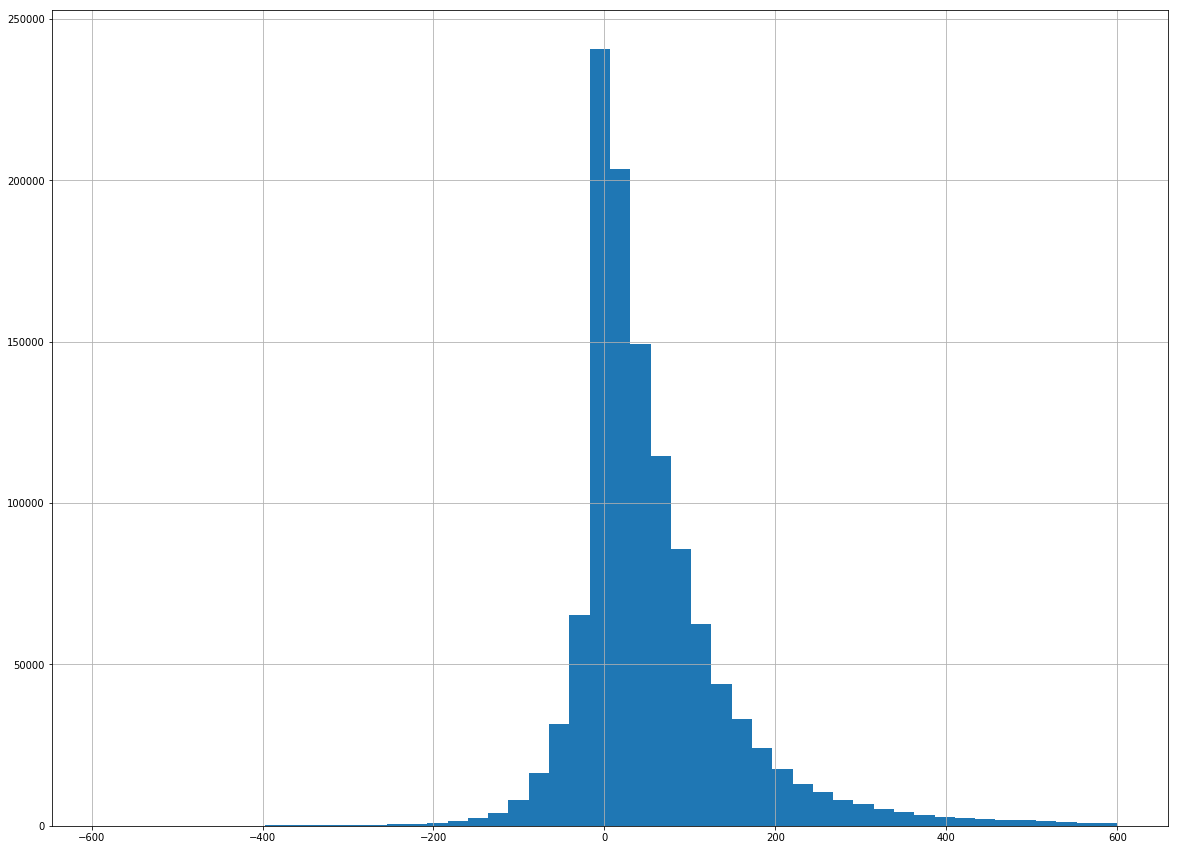

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
data["ve_arrival_time"].hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
import numpy as np
our_rmse = np.sqrt(data["ve_arrival_time"].apply(lambda x: x**2).sum() / len(data["ve_arrival_time"]))
our_rmse

108.68999509456962

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import numpy as np

class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, include_stops_away=False, include_route_id=False):
        self.include_stops_away = include_stops_away
        self.include_route_id = include_route_id
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(["predictions_id", 
                       "predictions_trip_id", 
                       "predictions_stop_sequence",
                       "predictions_vehicle_event_id",
                       "predictions_vehicle_id",
                       "predictions_file_timestamp",],
                      axis=1)

class IsStoppedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        result = X.copy()
        result['is_stopped'] = X['predictions_boarding_status'].notnull()
        return result.drop('predictions_boarding_status', axis=1)

class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        new_data = X.copy()
        datetimes = new_data['predictions_file_timestamp'].apply(
            lambda x: datetime.fromtimestamp(x),
        )
        predictions_day_of_week = datetimes.apply(lambda x: x.weekday())
        predictions_time_bin = datetimes.apply(self._timestamp_bin)
        new_data['predictions_day_of_week'] = predictions_day_of_week
        new_data['predictions_time_bin'] = predictions_time_bin
        return new_data
    
    def _timestamp_bin(self, timestamp):
        return timestamp.hour * 4 + timestamp.minute // 15

class ColumnOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        enc = OneHotEncoder()
        one_hotted = enc.fit_transform(X[self.column].values.reshape(-1,1))
        return np.concatenate((X.drop(self.column, axis=1), one_hotted), axis=1)
    
class DebugTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print(X.info())
        return X

class AccuracyBinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        copy = X.copy()
        copy["accuracy_bin"] = (copy['predictions_arrival_time'] - copy['predictions_file_timestamp']).apply(self._accuracy_bin)
        return copy
        
    def _accuracy_bin(self, seconds):
        if seconds < -30:
            return 'na-'
        elif -30 <= seconds < 180:
            return '0-3'
        elif 180 <= seconds < 360:
            return '3-6'
        elif 360 <= seconds < 720:
            return '6-12'
        elif 720 <= seconds < 1800:
            return '12-30'
        else:
            return 'na+'

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

passthrough_features = [ #'predictions_arrival_time',
                        'is_stopped',
                        'predictions_stops_away',
                        #'predictions_file_timestamp',
                        #'predictions_direction_id'
]

column_transformer = ColumnTransformer([
    ('pass', 'passthrough', passthrough_features),
    ('1hot', OneHotEncoder(), ['predictions_stop_id', 
                               #'predictions_route_id', 
                               'predictions_day_of_week',
                               'accuracy_bin',
                               'predictions_time_bin'])
])

predictions_pipeline = Pipeline([
    ('timestamp', TimestampTransformer()),
    ('is_stopped', IsStoppedTransformer()),
    ('accuracy_bin', AccuracyBinTransformer()),
    ('col_transformer', column_transformer)
])

In [10]:
fitted = predictions_pipeline.fit_transform(strat_train_set)

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(fitted, train_labels)

predictions = lin_reg.predict(fitted)
predictions

from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(train_labels, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

ct = predictions_pipeline.named_steps['col_transformer']
(_, _, passthrough_cols) = ct.transformers[0]
onehot_cols = ct.named_transformers_['1hot'].get_feature_names()

features = passthrough_cols + onehot_cols.tolist()

sorted(zip(lin_reg.coef_, features))

lin_reg.intercept_

from sklearn.ensemble import RandomForestRegressor

rand_forest = RandomForestRegressor(n_estimators=10, n_jobs=8)
rand_forest.fit(fitted, train_labels)

predictions = rand_forest.predict(fitted)
predictions

from sklearn.metrics import mean_squared_error
forest_mse = mean_squared_error(train_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

ct = predictions_pipeline.named_steps['col_transformer']
(_, _, passthrough_cols) = ct.transformers[0]
onehot_cols = ct.named_transformers_['1hot'].get_feature_names()

features = passthrough_cols + onehot_cols.tolist()

sorted(zip(rand_forest.feature_importances_, features))